In [1]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import string
import re

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [2]:
# convert text to lowercase 
def text_lowercase(text):
    return text.lower()

In [3]:
# remove numbers or convert the numbers into their textual representations 
def remove_numbers(text):
    result = re.sub(r'\d+', '', text)
    return result

In [4]:
# remove punctuations
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

In [5]:
# To remove leading and ending spaces
def remove_whitespace(text):
    return  " ".join(text.strip().split())

In [6]:
# "Stop words" are the most common words in a language like "the", "a", "on", "is", "all", etc. 
# These words do not carry important meaning so that they can safely be removed 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
  
# remove stopwords function
def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in stop_words]
    return filtered_text

In [7]:
# Remove short words
def remove_short_words(l_token):
    return [word for word in l_token if len(word)>3]

In [8]:
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
stemmer = PorterStemmer()
  
# stem words in the list of tokenised words
def stem_words(text):
    if isinstance(text, list):
        stems = [stemmer.stem(word) for word in text]
    else:
        word_tokens = word_tokenize(text)
        stems = [stemmer.stem(word) for word in word_tokens]
    return stems

In [9]:
!pip3 install pyLDAvis==2.1.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97738 sha256=f760001d7ea8e6b6b65671c874adef32a94f3b7a627ccd3c020af51c834076e4
  Stored in directory: /root/.cache/pip/wheels/31/8c/a0/24a443892f2134e691d59c8c6c35e19821e02f85e49871f8fd
Successfully built pyLDAvis


In [10]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/usr/local/lib/python3.8/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Iterable


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [13]:
filename = '/content/drive/MyDrive/Elon_Musk_project/tweets_with_stats_check.csv'

df_tweets = pd.read_csv(filename)
df_tweets

,Tweet_ID,Tweet,Created_date,Followers_count,Favorite_count,Retweet_count,Friends_count
0,1593551192176500736,@lionxmah @folha ?,2022-11-18 10:26:25,119900621,2958,126,136
1,1593541440671338496,@AOC You’re welcome,2022-11-18 09:47:40,119900654,545859,21612,136
2,1593535742285750272,@WholeMarsBlog Record numbers of users are log...,2022-11-18 09:25:02,119929179,54725,5398,136
3,1593528527873200130,@piersmorgan Seriously,2022-11-18 08:56:22,119929195,131021,4527,136
4,1593494261038649344,https://t.co/JU073T756X,2022-11-18 06:40:12,119929187,342389,23565,136
...,...,...,...,...,...,...,...
1364,1563292201043431424,Countries should be increasing nuclear power g...,2022-08-26 22:27:59,119930115,299848,34477,136
1365,1563291582429687809,@teslaownersSV @ICannot_Enough LotR/HG2G,2022-08-26 22:25:32,119930191,2902,163,136
1366,1563291162114670600,@ICannot_Enough It is safe to say that our out...,2022-08-26 22:23:52,119930148,23687,887,136
1367,1563255562133209088,@ID_AA_Carmack Similarly high cycle life with ...,2022-08-26 20:02:24,119930162,4729,260,136


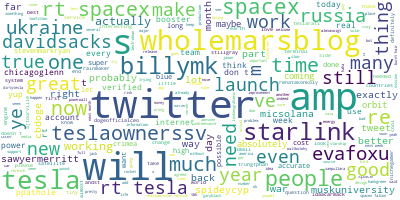

In [15]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(df_tweets["Tweet"].apply(text_lowercase).apply(remove_numbers).apply(remove_punctuation).apply(remove_whitespace)))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=500, max_font_size=40, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [16]:
data = df_tweets['Tweet'].dropna().values.tolist()
preprocessed_custom = df_tweets['Tweet'].dropna().apply(text_lowercase).apply(remove_numbers).apply(remove_punctuation).apply(remove_whitespace).apply(remove_stopwords).apply(remove_short_words).apply(stem_words).values.tolist()
preprocessed_simple = list(sent_to_words(data))
preprocessed_custom[:1]

[['lionxmah', 'folha']]

In [17]:
# Create Dictionary
id2word_custom = corpora.Dictionary(preprocessed_custom)

# Create Corpus
texts_custom = preprocessed_custom

# Term Document Frequency
corpus_custom = [id2word_custom.doc2bow(text) for text in texts_custom]

# View
print(corpus_custom[:1])

[[(0, 1), (1, 1)]]


In [18]:
# Create Dictionary
id2word_simple = corpora.Dictionary(preprocessed_simple)

# Create Corpus
texts_simple = preprocessed_simple

# Term Document Frequency
corpus_simple = [id2word_simple.doc2bow(text) for text in texts_simple]

# View
print(corpus_simple[:1])

[[(0, 1), (1, 1)]]


In [19]:
# Build LDA model
lda_model_custom = gensim.models.ldamodel.LdaModel(corpus=corpus_custom,
                                                   id2word=id2word_custom,
                                                   num_topics=10, 
                                                   random_state=100,
                                                   update_every=1,
                                                   chunksize=100,
                                                   passes=10,
                                                   alpha='auto',
                                                   per_word_topics=True)

In [20]:
# Build LDA model
lda_model_simple = gensim.models.ldamodel.LdaModel(corpus=corpus_simple,
                                                   id2word=id2word_simple,
                                                   num_topics=10, 
                                                   random_state=100,
                                                   update_every=1,
                                                   chunksize=100,
                                                   passes=10,
                                                   alpha='auto',
                                                   per_word_topics=True)

In [21]:
pprint(lda_model_custom.print_topics())

[(0,
  '0.064*"spacex" + 0.045*"wholemarsblog" + 0.025*"sawyermerritt" + '
  '0.023*"much" + 0.020*"spideycyp" + 0.020*"ukrain" + 0.018*"russia" + '
  '0.017*"probabl" + 0.015*"culturaltutor" + 0.014*"renatakonkoli"'),
 (1,
  '0.041*"need" + 0.018*"work" + 0.018*"team" + 0.016*"improv" + '
  '0.015*"product" + 0.015*"pleas" + 0.014*"twitter" + 0.012*"import" + '
  '0.010*"take" + 0.010*"oper"'),
 (2,
  '0.041*"time" + 0.036*"billymk" + 0.031*"year" + 0.026*"come" + 0.016*"hope" '
  '+ 0.014*"mayb" + 0.013*"long" + 0.012*"actual" + 0.012*"soon" + '
  '0.012*"right"'),
 (3,
  '0.089*"tesla" + 0.026*"engin" + 0.020*"month" + 0.016*"power" + '
  '0.013*"kristennetten" + 0.013*"nasaspaceflight" + 0.011*"giga" + '
  '0.011*"full" + 0.010*"test" + 0.009*"northmantrad"'),
 (4,
  '0.026*"twitter" + 0.023*"peopl" + 0.019*"thing" + 0.019*"better" + '
  '0.017*"energi" + 0.017*"batteri" + 0.014*"make" + 0.012*"design" + '
  '0.012*"back" + 0.012*"sciguyspac"'),
 (5,
  '0.045*"teslaownerssv" + 0.02

In [22]:
pprint(lda_model_simple.print_topics())

[(0,
  '0.023*"good" + 0.021*"culturaltutor" + 0.020*"cb_doge" + 0.018*"rbreich" + '
  '0.016*"teslarati" + 0.015*"launch" + 0.014*"renatakonkoly" + 0.013*"energy" '
  '+ 0.012*"little" + 0.011*"tarabull"'),
 (1,
  '0.142*"https" + 0.140*"co" + 0.021*"my" + 0.015*"week" + 0.014*"most" + '
  '0.014*"every" + 0.011*"stevenmarkryan" + 0.010*"back" + 0.008*"he" + '
  '0.008*"giga"'),
 (2,
  '0.069*"tesla" + 0.029*"teslaownerssv" + 0.019*"amp" + 0.019*"next" + '
  '0.018*"our" + 0.014*"rt" + 0.011*"end" + 0.010*"owners" + 0.010*"when" + '
  '0.010*"down"'),
 (3,
  '0.034*"from" + 0.022*"at" + 0.021*"amp" + 0.020*"has" + 0.019*"yes" + '
  '0.017*"true" + 0.017*"can" + 0.014*"better" + 0.013*"all" + 0.013*"time"'),
 (4,
  '0.030*"orbit" + 0.022*"muskuniversity" + 0.015*"tiny" + 0.013*"exactly" + '
  '0.013*"nasaspaceflight" + 0.013*"make" + 0.012*"engine" + 0.011*"falcon" + '
  '0.011*"full" + 0.011*"days"'),
 (5,
  '0.059*"for" + 0.043*"amp" + 0.034*"to" + 0.026*"starlink" + '
  '0.018*"sawy

In [23]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis_custom = pyLDAvis.gensim.prepare(lda_model_custom, corpus_custom, id2word_custom, sort_topics=False)
pyLDAvis.display(vis_custom)

/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:228: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info  = pd.DataFrame({'saliency': saliency, 'Term': vocab, \


In [24]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis_simple = pyLDAvis.gensim.prepare(lda_model_simple, corpus_simple, id2word_simple, sort_topics=False)
pyLDAvis.display(vis_simple)